In [1]:
import numpy as np
import matplotlib.pyplot as plt
import book_plots
from book_plots import plot_errorbars

### Part. 1. Two scale

**i**. Plotted the measurements of A and B with an assumed error of $\pm$ 8 lbs. The measurements falls between 160 and 170 so the only weight that makes sense must lie within 160 and 170 lbs.

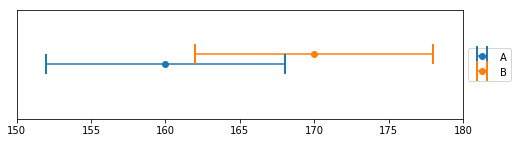

In [2]:
plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))

**ii**. The same measurements of A=160 and B=170, but with the error of A $\pm$ 3 lbs and the error of B is 3 times as much, $\pm$ 9 lbs.

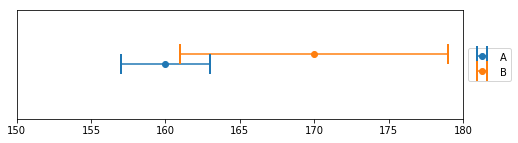

In [3]:
plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

The overlap of the error bars of A and B are the only possible true weight. This overlap is smaller than the error in A alone.

**iii**. Assume we know scale A is accurate to 1 lb. In other words, if we truly weigh 170 lbs, it could report 169, 170, or 171 lbs. We also know that scale B is accurate to 9 lbs. We do a weighing on each scale, and get A=160, and B=170. 

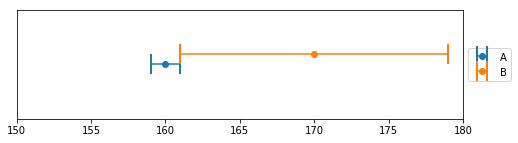

In [4]:
plot_errorbars([(160, 1, 'A'), (170, 9, 'B')], xlims=(150, 180))

Here we can see that the only possible weight is 161 lbs. This is an important result. With two relatively inaccurate sensors we are able to deduce an extremely accurate result.

### Part. 2. Scale weight for 10 days

In [5]:
weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

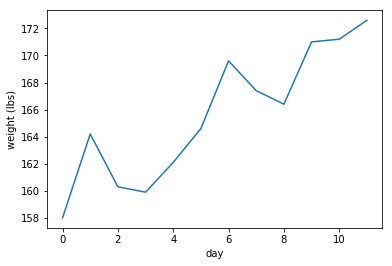

In [6]:
plt.plot(weights)
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.show()

#### Assumption 1: our weight did not change

In [7]:
ave = np.sum(weights) / len(weights)

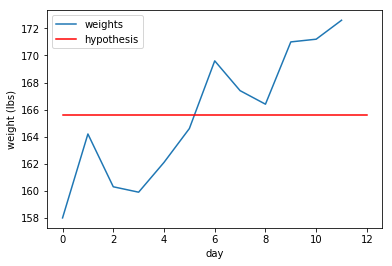

In [8]:
plt.plot(weights,label='weights')
plt.plot([0,12], [ave,ave], c='r', label='hypothesis')
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.legend(loc='best')
plt.show()

That doesn't look very convincing.

#### Assumption 2: we gained weight
Apply least squares fit

In [9]:
xs = range(len(weights))
line = np.poly1d(np.polyfit(xs, weights, 1))

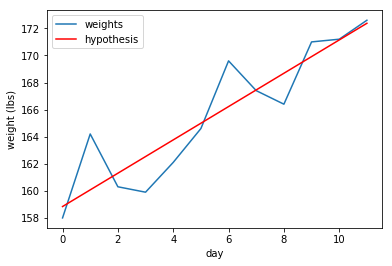

In [10]:
plt.plot(weights, label='weights')
plt.plot (xs, line(xs), c='r', label='hypothesis')
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.legend(loc='best')
plt.show()

#### Is it possible?
The first measurement was 158. We have no way of knowing any different, so let's accept that as our estimate. If our weight today is 158, what will it be tomorrow? Well, we think we are gaining weight at 1 lb/day, so our prediction is 159, like so:

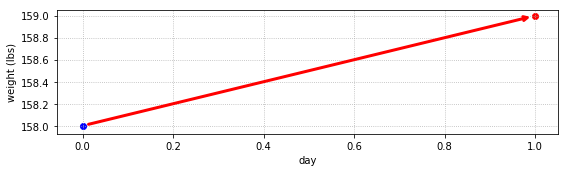

In [11]:
book_plots.plot_estimate_chart_1()

Let's look at the next measurement. We step on the scale again and it displays 164.2 lbs.

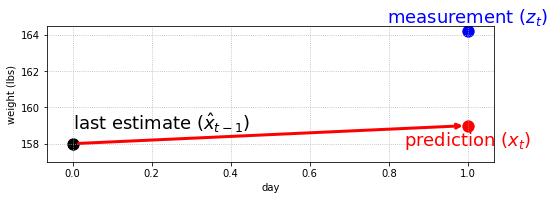

In [12]:
book_plots.plot_estimate_chart_2()

We have a problem. Our prediction doesn't match our measurement. But, that is what we expected, right? If the prediction was always exactly the same as the measurement, it would not be capable of adding any information to the filter. And, of course, there would be no reason to ever measure since our predictions are perfect

#### Key idea:
So what do we do? If we only form estimates from the measurement then the prediction will not affect the result. If we only form estimates from the prediction then the measurement will be ignored. If this is to work we need to take some kind of **blend of the prediction and measurement**.

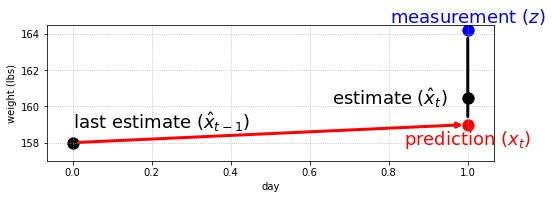

In [13]:
book_plots.plot_estimate_chart_3()

Now let's try a randomly chosen number to scale our estimate: $\frac{4}{10}$. Our estimate will be four tenths the measurement and the rest will be from the prediction. In other words, we are expressing a belief here, a belief that the prediction is somewhat more likely to be correct than the measurement. We compute that as

$$\mathtt{estimate} = \mathtt{prediction} + \frac{4}{10}(\mathtt{measurement} - \mathtt{prediction})$$
The difference between the measurement and prediction is called the residual, which is depicted by the black vertical line in the plot above. This will become an important value to use later on, as it is an exact computation of the difference between measurements and the filter's output. Smaller residuals imply better performance.

In [14]:
time_step = 1.0 
scale_factor = 4.0/10

In [15]:
def predict_using_gain_guess(weight, gain_rate):    
    # store the filtered results
    estimates, predictions = [weight], []

    # most filter literature uses 'z' for measurements
    for z in weights: 
        # predict new position
        prediction = weight + gain_rate * time_step

        # update filter 
        weight = prediction + scale_factor * (z - prediction)

        # save
        estimates.append(weight)
    return estimates

In [16]:
estimates = predict_using_gain_guess (weight=160, gain_rate=1)
estimates = estimates[1:]

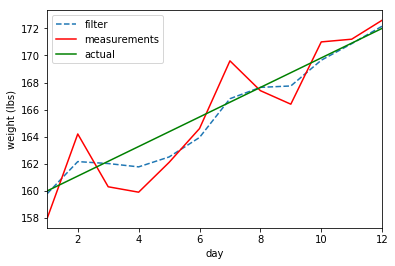

In [17]:
n = len(weights)
plt.xlim([1, n])
plt.plot (range(1, n+1), estimates, '--', label='filter')
plt.plot(range(1, n+1), weights, c='r', label='measurements')
plt.plot([1, n],[160, 160+n],c='g', label='actual')
plt.legend(loc=2)
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.show()

Of course the data will look good if we assume the conclusion, that our weight gain is around 1 lb/day! Let's see what the lter does if our initial guess is bad. Let's see what happens if I predict that there is **no** weight gain.

In [18]:
estimates = predict_using_gain_guess (weight=160, gain_rate=0)
estimates = estimates[1:]

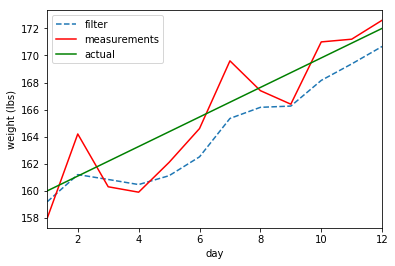

In [19]:
n = len(weights)
plt.xlim([1, n])
plt.plot (range(1, n+1), estimates, '--', label='filter')
plt.plot(range(1, n+1), weights, c='r', label='measurements')
plt.plot([1, n],[160, 160+n],c='g', label='actual')
plt.legend(loc=2)
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.show()

Clearly a filter that requires us to correctly guess a rate of change is not very useful.
Even if our initial guess was useful, the filter will fail as soon as that rate of change changes.

What if instead of just leaving the weight gain at the initial guess of 1 lb (or whatever), we compute it from the existing measurements and estimates.

This time I will use another arbitrarily chosen number, $\frac{1}{3}$. The equation is identical as for the weight estimate except we have to incorporate time because this is a rate (gain/day):

$$\text{new gain} = \text{old gain} + \frac{1}{3}\frac{\text{measurement - predicted weight}}{1 \text{ day}}
$$

In [20]:
weight = 160 # initial guess
gain_rate = 1.0 # initial guess

In [21]:
time_step = 1
weight_scale = 4/10
gain_scale = 1/3
estimates = []

In [22]:
for z in weights:
    # prediction step
    weight = weight + gain_rate*time_step
    gain_rate = gain_rate
    
    # update step
    residual = z - weight
    gain_rate = gain_rate + gain_scale * (residual/time_step)
    weight = weight + weight_scale * residual
    estimates.append(weight)

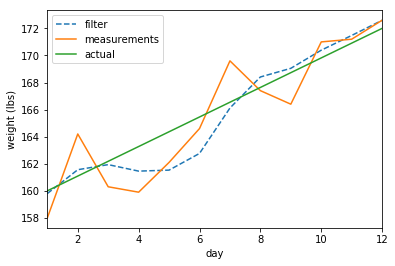

In [23]:
n = len(weights)
plt.xlim([1, n])
plt.plot (range(1, n+1), estimates, '--', label='filter')
plt.plot(range(1, n+1), weights, label='measurements')
plt.plot([1 ,n], [160,160+n], label='actual')
plt.legend(loc=2)
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.show()